In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os
import tensorflow as tf


In [2]:
df_holidays = pd.read_csv('holidays_events.csv', encoding = 'cp949', header = 0, parse_dates = ['date'])
df_oil = pd.read_csv("oil.csv", encoding = 'cp949', header = 0, parse_dates = ['date'])
df_stores = pd.read_csv("stores.csv", encoding = 'cp949', header = 0)
df_trans = pd.read_csv("transactions.csv", encoding = 'cp949', header = 0, parse_dates = ['date'])

df_train = pd.read_csv("train.csv", encoding = "cp949", header = 0, parse_dates = ['date'])
df_test = pd.read_csv("test.csv", encoding = "cp949", header = 0, parse_dates = ['date'])

In [3]:
li = [df_holidays, df_oil, df_stores, df_trans, df_train, df_test]
for i in range(len(li)):
    if 'sales' in li[i].columns:
        li[i].rename(columns = {'sales': 'y'}, inplace = True)
    if 'date' in li[i].columns:
        li[i].rename(columns = {'date' : 'ds'}, inplace = True)

In [4]:
def rmsle(y_hat, y):
    """ Compute Root Mean Squared Logarithmic Error """
    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y)))) ** 2) / len(y))
    return round(metric, 4)

In [5]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns = None):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

In [20]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis = -1)
        
        # slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the 'tf.data.Datasets' are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def plot(self, model = None, plot_col = 'T (degC)', max_subplots = 3):
    inputs, labels = self.example
    plt.figure(figsize = (12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f'{plot_col}[normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label = 'Inputs', marker = '.', zorder = -10)
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        
        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors = 'k', label = 'Labels', c = '#2ca02c', s = 64)

        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker = 'X', edgecolors = 'k', label = 'Predictions', c = '#ff7f0e', s = 64)
        
        if n == 0:
            plt.legend()
    
    plt.xlabel('Days')

def make_dataset(self, data):
    data = np.array(data, dtype = np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(data = data, targets = None, sequence_length = self.total_window_size,
                                                      sequence_stride = 1, shuffle = True, batch_size = 32, )
    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """ Get and cache an example batch of 'inputs, labels' for plotting. """
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

def compile_and_fit(model, window, MAX_EPOCHS = 20, learning_rate = 0.2, patience = 10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')

    model.compile(loss = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(learning_rate = learning_rate),
                  metrics = [tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs = MAX_EPOCHS,
                        validation_data = window.val,
                        callbacks = [early_stopping])
    
    return history

In [21]:
def get_last_available_week(df):
    # Get date of the last available week
    df = df.assign(diff_from_max_train_ds = df.ds - (df.ds.min() - timedelta(days = 1))) # -datetime.strptime(df.ds.min(), "%Y-%m-%d")
    df = df.assign(nb_weeks = np.ceil(df.diff_from_max_train_ds.dt.days / 7).astype('int'))
    df = df.assign(last_week_ds = df.ds - (df.nb_weeks * 7).map(lambda x: timedelta(x)))
    
    return df

def get_yhat(df):
    df = pd.merge(df,
                  df[['ds', 'store_nbr', 'family', 'prop_family_per_store']].rename(columns = {'prop_family_per_store' : 'last_week_prop_family_per_store'}),
                  left_on = ['last_week_ds', 'store_nbr', 'family'],
                  right_on = ['ds', 'store_nbr', 'family'],
                  how = 'left').drop(['diff_from_max_train_ds', 'nb_weeks', 'last_week_ds', 'ds_y'], axis = 1).rename(columns = {'ds_x': 'ds'})
    
    df = df.assign(yhat = df.yhat_store_nbr * df.last_week_prop_family_per_store)

    return df

In [22]:
train_df, test_df = df_train.copy(), df_test.copy()

# Cross validation
val_df = train_df[(train_df.ds >= '2017-08-01') & (train_df.ds <= '2017-08-15')]

val_df = pd.merge(get_last_available_week(val_df)[['id', 'ds', 'last_week_ds', 'store_nbr', 'family', 'y']],
                  train_df[['ds', 'store_nbr', 'family', 'y']],
                  left_on = ['last_week_ds', 'store_nbr', 'family'], right_on = ['ds', 'store_nbr', 'family'], how = 'left').rename(columns = {'ds_x': 'ds', 'y_x': 'y', 'y_y': 'yhat'})

print('RMSLE: %s'% rmsle(val_df.yhat, val_df.y))

RMSLE: 0.6124


In [23]:
submission_df = pd.merge(get_last_available_week(test_df)[['id', 'ds', 'last_week_ds', 'store_nbr', 'family']],
                         train_df[['ds', 'store_nbr', 'family', 'y']],
                         left_on = ['last_week_ds', 'store_nbr', 'family'], right_on = ['ds', 'store_nbr', 'family'], how = 'left')[['id', 'y']].rename(columns = {'y': 'sales'})

# submission_df.to_csv('submission.csv', index = False)

In [24]:
# Parameters
start_training_ds = '2017-01-01'
input_width = 1 * 7
label_width = 16

MAX_EPOCHS = 50
learning_rate = 0.001
scaling = ['standardisation', 'normalisation'][0]

# Reshape the dataframe
df = df_train[df_train.ds >= start_training_ds].assign(key = df_train['store_nbr'].astype('str') + '~' + df_train['family'])
df = pd.pivot_table(df, values = 'y', index = ['ds'], columns = 'key').reset_index()
date_time = df.ds
df = df.drop('ds', axis = 1)
df = df.iloc[:, :df.shape[1]]
column_indices = {name: i for i, name in enumerate(df.columns)}

# Split into train, val and test set
n = len(df)
test_df = df[-label_width:]
val_df = df[-(input_width + 2 * label_width):-label_width]
train_df = df[:-(input_width + label_width)]

print("Train set size: (%s, %s)"%(train_df.shape[0], train_df.shape[1]))
print("Validation set size: (%s, %s)"%(test_df.shape[0], test_df.shape[1]))
print("Test set size: (%s, %s) \n"%(val_df.shape[0], val_df.shape[1]))

num_features = df.shape[1]

# Perform normalisation
if scaling == 'standardisation':
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    train_df = train_df.fillna(0)
    val_df = (val_df - train_mean) / train_std
    val_df = val_df.fillna(0)
    test_df = (test_df - train_mean) / train_std
    test_df = test_df.fillna(0)

    train_df[train_df == np.inf] = 0
    val_df[val_df == np.inf] = 0
    test_df[test_df == np.inf] = 0

elif scaling == 'normalisation':
    scaler = MinMaxScaler(feature_range = (0, 1))
    train_df = pd.DataFrame(scaler.fit_transform(train_df), columns = train_df.columns)
    val_df = pd.DataFrame(scaler.transform(val_df), columns = val_df.columns)
    test_df = pd.DataFrame(scaler.transform(test_df), columns = test_df.columns)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.make_dataset = make_dataset
WindowGenerator.split_window = split_window
WindowGenerator.plot = plot

# Generate windows for training batches
window = WindowGenerator(input_width = input_width, label_width = label_width, shift = label_width, train_df = train_df, val_df = val_df, test_df = test_df)

model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.Conv1D(filters = 128, kernel_size = (input_width,), activation = 'relu'),
    tf.keras.layers.LSTM(128, return_sequences = False),
    tf.keras.layers.Dense(label_width * num_features, kernel_initializer = tf.initializers.zeros()),
    tf.keras.layers.Reshape([label_width, num_features])
])

print('Input shape:', window.example[0].shape)
print('Labels shape:', window.example[1].shape)
print('Output shape:', model(window.example[0]).shape)

history = compile_and_fit(model, window, MAX_EPOCHS, learning_rate)

Train set size: (204, 1782)
Validation set size: (16, 1782)
Test set size: (23, 1782) 

Input shape: (32, 7, 1782)
Labels shape: (32, 16, 1782)
Output shape: (32, 16, 1782)
Epoch 1/50
6/6 [==============================] - 2s 119ms/step - loss: 0.9129 - mean_absolute_error: 0.6963 - val_loss: 1.8132 - val_mean_absolute_error: 0.7000
Epoch 2/50
6/6 [==============================] - 0s 51ms/step - loss: 0.8528 - mean_absolute_error: 0.6671 - val_loss: 1.7191 - val_mean_absolute_error: 0.6547
Epoch 3/50
6/6 [==============================] - 0s 53ms/step - loss: 0.7682 - mean_absolute_error: 0.6240 - val_loss: 1.6579 - val_mean_absolute_error: 0.6235
Epoch 4/50
6/6 [==============================] - 0s 55ms/step - loss: 0.7225 - mean_absolute_error: 0.6001 - val_loss: 1.6404 - val_mean_absolute_error: 0.6148
Epoch 5/50
6/6 [==============================] - 0s 51ms/step - loss: 0.6982 - mean_absolute_error: 0.5870 - val_loss: 1.6312 - val_mean_absolute_error: 0.6094
Epoch 6/50
6/6 [=====

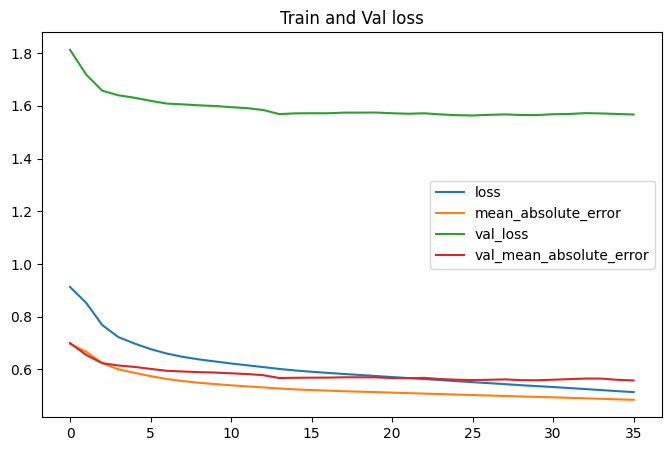

In [26]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.title('Train and Val loss')
plt.show()

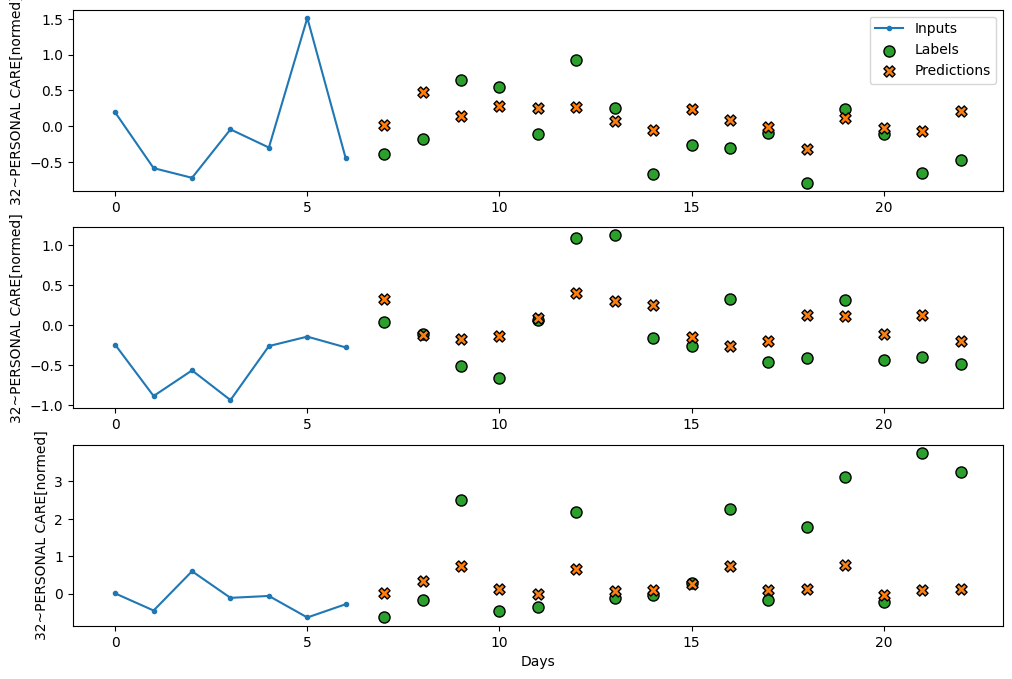

In [31]:
window.plot(model, plot_col = random.choice(train_df.columns))

In [35]:
# Generate predictions for the test period taking the last values of the validation period
y_hat = model.predict(val_df.values[-input_width:, :].reshape(1, input_width, num_features))
predict_df = (pd.DataFrame(y_hat.reshape(label_width, num_features), columns=df.columns)*train_std + train_mean).assign(ds=date_time[-label_width:].values)
columns_to_keep = [e for e in predict_df.columns if '~' in e or e == 'ds'] 
predict_df = predict_df[columns_to_keep]
predict_df = predict_df.melt(id_vars =['ds'], value_vars =[c for c in predict_df.columns if c != 'ds'])
predict_df[['store_nbr', 'family']] = predict_df.key.str.split('~', expand=True)
predict_df = predict_df.rename(columns={'value': 'y_hat'})
predict_df['store_nbr'] = predict_df.store_nbr.astype('int')
predict_df.drop('key', axis=1, inplace=True)

predict_df = pd.merge(df_train.drop('id', axis=1), predict_df, on=['ds', 'store_nbr', 'family'], how='left')
predict_df['y_hat'] = np.clip(predict_df.y_hat, 0, np.inf)

predict_df.tail()

1/1 [==============================] - 0s 24ms/step


,ds,store_nbr,family,y,onpromotion,y_hat
3000883,2017-08-15,9,POULTRY,438.133,0,356.858689
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,120.128261
3000885,2017-08-15,9,PRODUCE,2419.729,148,2372.226570
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,3.280255
3000887,2017-08-15,9,SEAFOOD,16.000,0,16.546017


In [37]:
predict_df['error'] = (np.log(1 + predict_df[~predict_df.y_hat.isnull()].y) - np.log(1 + predict_df[~predict_df.y_hat.isnull()].y_hat))**2
print("RMSLE: %s" %rmsle(predict_df[~predict_df.y_hat.isnull()].y, predict_df[~predict_df.y_hat.isnull()].y_hat))

RMSLE: 0.5466


In [38]:
predict_df['key'] = predict_df['store_nbr'].astype(str) + '~' + predict_df['family'].astype(str)
rmsle_per_ts_df = predict_df.groupby('key').agg({'error': 'sum'}).sort_values('error', ascending=False).reset_index()
rmsle_per_ts_df.head(10)

,key,error
0,45~SCHOOL AND OFFICE SUPPLIES,302.776283
1,47~SCHOOL AND OFFICE SUPPLIES,285.455952
2,50~SCHOOL AND OFFICE SUPPLIES,281.107923
3,48~SCHOOL AND OFFICE SUPPLIES,272.229401
4,46~SCHOOL AND OFFICE SUPPLIES,264.591653
5,49~SCHOOL AND OFFICE SUPPLIES,263.282273
6,44~SCHOOL AND OFFICE SUPPLIES,212.258209
7,9~SCHOOL AND OFFICE SUPPLIES,190.103829
8,20~SCHOOL AND OFFICE SUPPLIES,137.566454
9,18~SCHOOL AND OFFICE SUPPLIES,99.342494


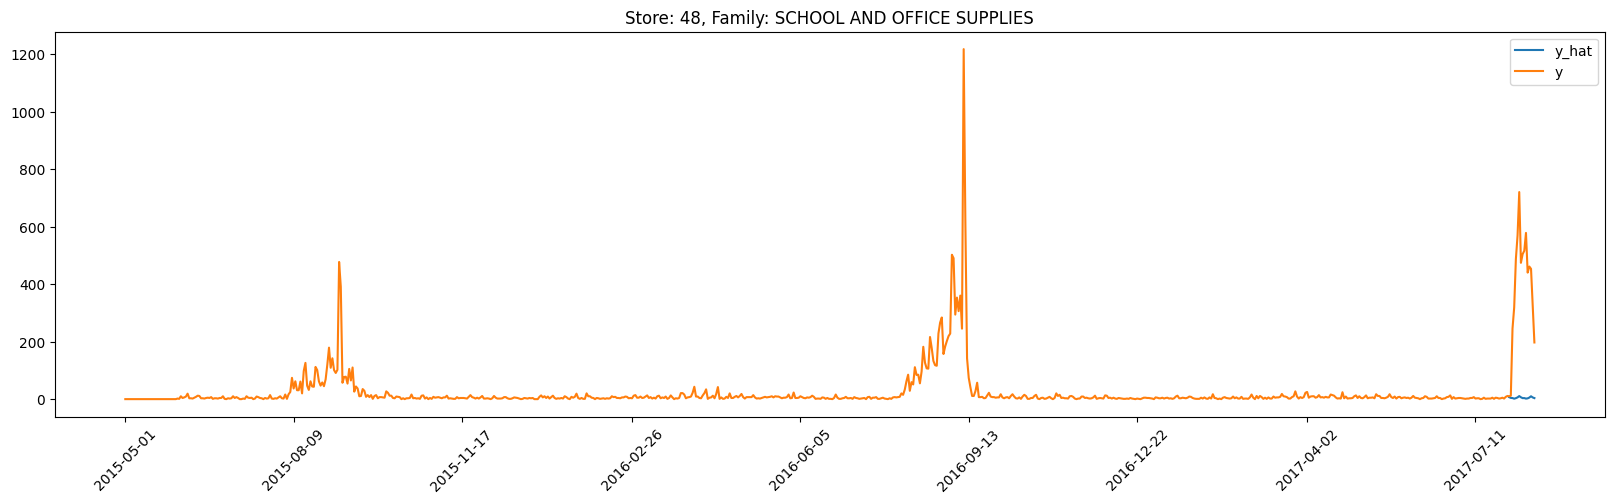

In [41]:
plot_ds_range = ['2015-05-01', predict_df.ds.iloc[-1]]
fig, ax = plt.subplots(figsize=(20, 5))
unique_keys = set(zip(df_train.store_nbr, df_train.family))
key = random.choice(list(unique_keys))
key = [48, 'SCHOOL AND OFFICE SUPPLIES']
ts = predict_df[(predict_df.store_nbr == key[0]) & (predict_df.family == key[1])]
ts = ts[(ts.ds >= plot_ds_range[0]) & (ts.ds <= plot_ds_range[1])]

# plt.plot(ts.ds, ts.onpromotion*np.median(ts.y), label='promotion')
plt.plot(ts.ds, ts.y_hat, label='y_hat')
plt.plot(ts.ds, ts.y, label='y')
plt.title("Store: " + str(key[0]) + ", Family: " + key[1])
plt.legend()
ax.set_xticks(np.array(ts.ds)[::100])
ax.tick_params(axis='x',rotation=45)
plt.show()